In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy.linalg as la

from data import *
from models import train, RNN

# Below snippit taken from PyTorch quickstart tutorial
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


# Data generation functions

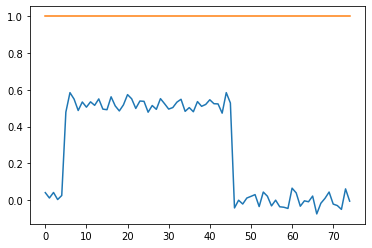

In [6]:
u, y = single_decision(16*3.2/100)
plt.plot(u)
plt.plot(y)

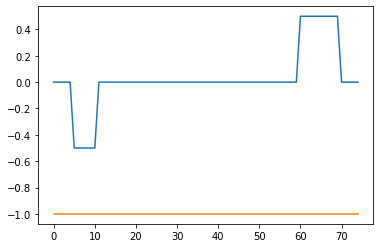

In [7]:
u, y = parametric(10, 34)
plt.plot(u)
plt.plot(y)

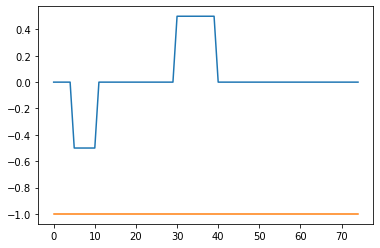

In [8]:
u, y = parametric(10, 34, pause=20)
plt.plot(u)
plt.plot(y)

# RNN Class

In [28]:
# class RNN(nn.Module):

#     def __init__(self, network_size=128,rank=1):

#         super(RNN, self).__init__()
#         self.network_size = network_size
#         self.rank=rank

#         # Weight initialization
#         self.m = nn.Parameter(torch.Tensor(network_size, rank))
#         self.n = nn.Parameter(torch.Tensor(network_size, rank))
#         self.wi = torch.Tensor(network_size)
#         self.w = torch.Tensor(network_size, 1)
#         self.x0= torch.Tensor(network_size, 1)
#         self.tau = 100 #ms
#         self.dt = 20 #ms

#         # Activation function
#         self.activation = nn.Tanh()

#         with torch.no_grad():
#             self.m.normal_(std=1)
#             self.n.normal_(std=1)
#             self.w.normal_(std=4)
#             self.x0.zero_()
#             self.wi.normal_(std=1)

            
#     def forward(self, u, visible_activity=False):
        
#         # print(u)
#         if len(u.shape) == 1:
#             u = u.unsqueeze(0)
            
#         input_len=u.size(1)
#         batch_size=u.size(0)
        
#         x = torch.zeros(batch_size, self.network_size)
#         z = torch.zeros(u.shape)

#         r = self.activation(x)

#         if visible_activity:
#             unit_activity = torch.zeros(batch_size, input_len+1, self.network_size)
#             unit_activity[:,0,:] = x

#         for i in range(input_len):
#             delta_x = (
#                 -x
#                 + r.matmul(self.n).matmul(self.m.t()) / self.network_size
#                 + torch.outer(u[:,i], self.wi.squeeze())
#             ) * (self.dt / self.tau)

#             x = x + delta_x
#             r = self.activation(x)
#             if visible_activity:
#                 unit_activity[:,i+1,:] = x

#             output = torch.matmul(r, self.w) / self.network_size
#             z[:, i] = output.squeeze()

#         if visible_activity:
#             return z, unit_activity
#         else:
#             return z
        
#     def get_mean_cov(self):
#         """
#         Returns the mean and covariance matrix of internal
#         parameters in the form [m, n, wi, w]
#         """
#         m=self.m.detach().numpy()
#         n=self.n.detach().numpy()
#         wi=self.wi.detach().numpy()
#         w=self.w.detach().numpy()
        
#         packaged_vectors = np.zeros((2*self.rank+2, self.network_size))
        
#         packaged_vectors[0:self.rank] = m.T
#         packaged_vectors[self.rank:2*self.rank] = n.T
#         packaged_vectors[2*self.rank] = wi.flatten()
#         packaged_vectors[2*self.rank+1] = w.flatten()
        
#         print(packaged_vectors)

#         mean = np.mean(packaged_vectors, axis=1)
#         cov_matrix = np.cov(packaged_vectors)

#         return torch.tensor(mean), torch.tensor(cov_matrix)

# Rank-One Tests

In [2]:
sd_single_data = SingleDecisionDataset(1)
train_dataloader = DataLoader(sd_single_data, batch_size=1)
model = RNN()
train(train_dataloader, model, device)

loss: 1.017368  [    1/    1]


In [4]:
mean, cov = model.get_mean_cov()
print(mean)
print(cov)

tensor([-0.0237, -0.0160,  0.0318, -0.4353], dtype=torch.float64)
tensor([[ 9.5534e-01, -7.4685e-04,  4.9229e-02,  3.8640e-01],
        [-7.4685e-04,  9.8625e-01,  5.0092e-02, -3.1702e-01],
        [ 4.9229e-02,  5.0092e-02,  1.1249e+00, -6.2130e-01],
        [ 3.8640e-01, -3.1702e-01, -6.2130e-01,  1.6640e+01]],
       dtype=torch.float64)


In [5]:
sd_single_data = SingleDecisionDataset(5)
train_dataloader = DataLoader(sd_single_data, batch_size=5)
model = RNN()
train(train_dataloader, model, device)

loss: 1.000512  [    5/    5]


In [6]:
sd_dataset = SingleDecisionDataset(8000)
train_dataloader = DataLoader(sd_dataset, batch_size=32)

model = RNN()
train(train_dataloader, model, device)

loss: 1.000339  [   32/ 8000]
loss: 0.435012  [ 3232/ 8000]
loss: 0.000973  [ 6432/ 8000]


torch.Size([75])
(1, 76, 128)


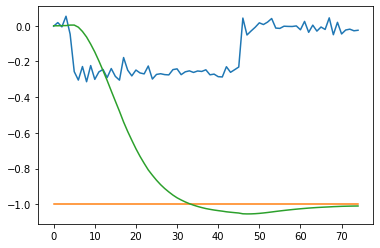

In [13]:
strength = -8
u, y = single_decision(strength*3.2/100)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)


# Full rank single_decision

In [34]:
sd_dataset = SingleDecisionDataset(8000)
train_dataloader = DataLoader(sd_dataset, batch_size=32)

model = RNN(rank=128)
train(train_dataloader, model, device)

loss: 0.899254  [   32/ 8000]
loss: 0.000462  [ 3232/ 8000]
loss: 0.000001  [ 6432/ 8000]


torch.Size([75])
(1, 76, 128)


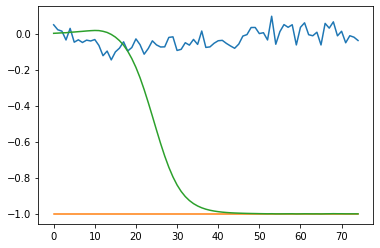

In [35]:
strength = -2
u, y = single_decision(strength*3.2/100)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)

# Rank 2 Parametric

In [31]:
p_data = ParametricDataset(1)
train_dataloader = DataLoader(p_data, batch_size=1)
model = RNN(rank=2)
train(train_dataloader, model, device)


loss: 0.127391  [    1/    1]


In [32]:
mean, cov = model.get_mean_cov()

[[ 1.54896677e+00  1.18352592e+00 -1.54162943e+00 -4.91570860e-01
  -8.15094054e-01  4.37790662e-01 -6.17817998e-01 -9.99394000e-01
   6.66220129e-01  1.82275259e+00 -1.67838156e-01 -1.18802142e+00
   5.64769387e-01  4.51779515e-01  6.23048425e-01 -1.15702987e+00
   1.44465372e-01  7.60727286e-01  8.86606574e-01  1.92404926e+00
  -1.14954722e+00  3.51166755e-01 -8.97518158e-01 -1.57491195e+00
  -1.74406743e+00  5.51218688e-01  7.77389824e-01  1.39388704e+00
   1.47009873e+00  1.17794156e+00 -4.84786391e-01  5.86692333e-01
  -9.69174027e-01  4.63979959e-01  2.44935393e-01 -1.03812420e+00
  -1.32936084e+00 -2.63734311e-01  5.22367299e-01 -5.48323154e-01
   1.21469522e+00  1.09309661e+00  2.57091373e-01  1.87952626e+00
   5.05914330e-01  3.75567287e-01 -6.90563083e-01 -1.79062080e+00
   1.71628058e-01  1.07527941e-01  1.67067647e+00 -1.55324852e+00
  -6.76046252e-01 -2.49641925e-01 -1.84784639e+00 -2.70647454e+00
  -1.17799926e+00 -3.84819984e-01 -3.13891053e-01 -3.77638698e-01
   2.05443

In [13]:
p_data = ParametricDataset(5)
train_dataloader = DataLoader(p_data, batch_size=5)
model = RNN(rank=2)
train(train_dataloader, model, device)

loss: 0.379586  [    5/    5]


### Rank 2 network overfits on 1 sample parametric dataset (GOOD!)

In [7]:
p_data = ParametricDataset(1)
train_dataloader = DataLoader(p_data, batch_size=1)
model = RNN(rank=2)

for _ in range(200):
    train(train_dataloader, model, device, T=5)

loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.000000  [    1/    1]
loss: 0.00

In [11]:
p_data = ParametricDataset(32000)
train_dataloader = DataLoader(p_data, batch_size=32)
model = RNN(rank=2)
train(train_dataloader, model, device, T=5, lr=5e-3)

loss: 0.295282  [   32/32000]
loss: 0.106136  [ 3232/32000]
loss: 0.090801  [ 6432/32000]
loss: 0.137575  [ 9632/32000]
loss: 0.107656  [12832/32000]
loss: 0.114125  [16032/32000]
loss: 0.137373  [19232/32000]
loss: 0.098361  [22432/32000]
loss: 0.119138  [25632/32000]
loss: 0.099000  [28832/32000]


torch.Size([75])
(1, 76, 128)


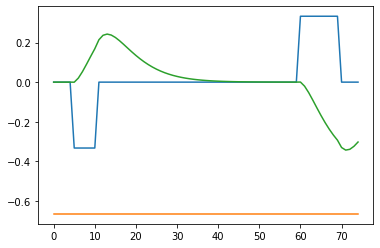

In [12]:
u, y = parametric((14, 30))
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)

In [13]:
pause_lengths = np.arange(25, 51, 5)
model = RNN(rank=2)

for pl in pause_lengths:
    p_data = ParametricDataset(6400, pause=pl)
    train_dataloader = DataLoader(p_data, batch_size=32)
    train(train_dataloader, model, device)
    

loss: 0.215331  [   32/ 6400]
loss: 0.133979  [ 3232/ 6400]
loss: 0.118980  [   32/ 6400]
loss: 0.071791  [ 3232/ 6400]
loss: 0.012556  [   32/ 6400]
loss: 0.005645  [ 3232/ 6400]
loss: 0.007833  [   32/ 6400]
loss: 0.003295  [ 3232/ 6400]
loss: 0.017027  [   32/ 6400]
loss: 0.008438  [ 3232/ 6400]
loss: 0.029729  [   32/ 6400]
loss: 0.042594  [ 3232/ 6400]


torch.Size([75])
(1, 76, 128)


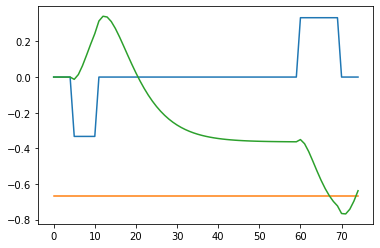

In [16]:
u, y = parametric((14, 30))
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)